# E7 - Decision Trees - Bagging

Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [1]:
# Librerías

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import BaggingClassifier

from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

# Parte 1 - Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [2]:
# read the data and set "datetime" as the index
bikes = pd.read_csv('Dataset/bikeshare.csv', index_col='datetime', parse_dates=True)

# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

# create "hour" as its own feature
bikes['hour'] = bikes.index.hour
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [3]:
bikes.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23


- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

In [4]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

<AxesSubplot:xlabel='hour'>

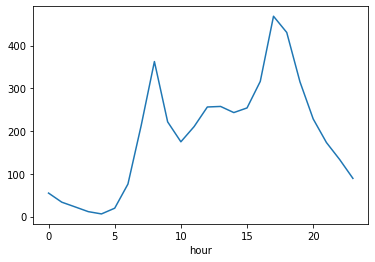

In [6]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot()

Plot for workingday == 0 and workingday == 1

In [7]:
# hourly rental trend for "workingday=0"


In [8]:
# hourly rental trend for "workingday=1"


In [9]:
# combine the two plots


Write about your findings

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

# Parte 2 - Bagging

## Mashable news stories analysis

Predicting if a news story is going to be popular

In [10]:
df = pd.read_csv('Dataset/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [11]:
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [12]:
y.describe()

count    6000.000000
mean        0.500000
std         0.500042
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: Popular, dtype: float64

In [13]:
y.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,3000,0.5
0,3000,0.5


In [14]:
X.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,358.138833,10.368667,547.428833,0.527732,0.961333,0.665823,11.874000,3.272500,4.954667,1.463167,...,0.357497,0.097194,0.762009,-0.265334,-0.530531,-0.110047,0.296854,0.077178,0.343496,0.167633
std,210.734614,2.106140,510.232776,0.148356,0.192815,0.167740,13.444103,4.262895,8.635916,4.508144,...,0.112586,0.076585,0.256845,0.133800,0.294477,0.100482,0.334117,0.282790,0.186815,0.240462
min,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,175.000000,9.000000,231.000000,0.465950,1.000000,0.619624,4.000000,1.000000,1.000000,0.000000,...,0.308693,0.050000,0.600000,-0.340000,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,345.000000,10.000000,391.000000,0.541477,1.000000,0.689119,8.000000,2.000000,1.000000,0.000000,...,0.364237,0.100000,0.800000,-0.260185,-0.500000,-0.100000,0.200000,0.000000,0.500000,0.016667
75%,544.250000,12.000000,719.000000,0.614980,1.000000,0.756237,15.000000,4.000000,7.000000,1.000000,...,0.419669,0.100000,1.000000,-0.191273,-0.300000,-0.050000,0.500000,0.166667,0.500000,0.250000
max,731.000000,19.000000,8474.000000,0.967742,1.000000,1.000000,304.000000,116.000000,111.000000,91.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


In [15]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Train vs test
table = [[y_train.describe(), y_test.describe()]]
headers = ['Train', 'Test']
print(tabulate(table,headers))

Train                          Test
-----------------------------  -----------------------------
count    4500.000000           count    1500.000000
mean        0.502444           mean        0.492667
std         0.500050           std         0.500113
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         1.000000           50%         0.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  Name: Popular, dtype: float64


In [16]:
y_train.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,2261,0.502444
0,2239,0.497556


In [17]:
y_test.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,761,0.507333
1,739,0.492667


# Exercise 7.6

Estimate a Decision Tree Classifier and a Logistic Regression

Evaluate using the following metrics:
* Accuracy
* F1-Score

### i) Árbol de Decisión

In [18]:
# list of values to try for max_depth
max_depth_range = range(1, 31)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

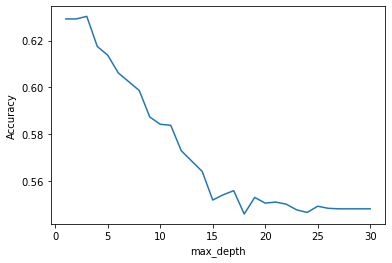

In [19]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [20]:
# show the best accuracy and the corresponding max_depth
tunning=sorted(zip(accuracy_scores, max_depth_range))[::-1][0]
print("Best accuracy",tunning[0])
print("Max Depth",tunning[1])

Best accuracy 0.6304444444444444
Max Depth 3


In [21]:
# once best max_depth is selected, so fit a tree using that parameter
clf = DecisionTreeClassifier(max_depth=tunning[1], random_state=123)
accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=123)

In [22]:
# compute feature importances (top 10)
feature_cols = X.columns[X.columns.str.startswith('C') == False]

pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance',ascending=False).head(10)

,feature,importance
26,kw_avg_avg,0.719798
21,kw_min_max,0.104722
25,kw_max_avg,0.090037
20,kw_avg_min,0.049868
23,kw_avg_max,0.035574
0,timedelta,0.000000
32,weekday_is_wednesday,0.000000
34,weekday_is_friday,0.000000
35,weekday_is_saturday,0.000000
36,weekday_is_sunday,0.000000


In [23]:
# predict 
y_pred = clf.predict(X_test)
y_pred=pd.DataFrame(y_pred)

# real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.462667
std         0.500113           std         0.498771
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         0.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [24]:
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[522, 239],
       [284, 455]])

In [25]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6513333333333333
F1 score: 0.6350314026517794
Precision: 0.6556195965417867
Recall: 0.6156968876860622


### ii) Regresión Logistica

In [26]:
# model
logreg = LogisticRegression()

# fit and predict
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
y_pred=pd.DataFrame(y_pred)

In [27]:
# real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.494000
std         0.500113           std         0.500131
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         0.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [28]:
# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[501, 260],
       [258, 481]])

In [29]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6546666666666666
F1 score: 0.6500000000000001
Precision: 0.6491228070175439
Recall: 0.6508795669824087


# Exercise 7.7

i) Estimate 300 bagged samples

### 300 bagged samples

In [54]:
# set a seed for reproducibility
seed = np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 300

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [55]:
# grow each tree deep
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=n_B, 
                          bootstrap=True, oob_score=True, random_state=seed)

# DataFrame for storing predicted from each tree
y_pred = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_tree = X_train.iloc[samples[i], :]
    y_train_tree = y_train.iloc[samples[i]]
    bagreg.fit(X_train_tree, y_train_tree)
    y_pred.append(bagreg.predict(X_test))
    
y_pred = np.transpose(pd.DataFrame(y_pred))
y_pred

KeyboardInterrupt: 

In [32]:
# set a seed for reproducibility
seed=np.random.seed(123)

# number of bagged samples
B=300

# model
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=B, 
                          bootstrap=True, oob_score=True, random_state=seed)

# fit and predict
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred=pd.DataFrame(y_pred)

In [33]:
# Real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.497867
std         0.500113           std         0.175126
min         0.000000           min         0.026667
25%         0.000000           25%         0.376667
50%         0.000000           50%         0.503333
75%         1.000000           75%         0.626667
max         1.000000           max         0.930000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [34]:
# calculate RMSE
np.sqrt(mean_squared_error(y_test, y_pred))

0.46052597948191565

ii) Estimate the following set of classifiers:

* 100 Decision Trees where max_depth=None
* 100 Decision Trees where max_depth=2
* 100 Logistic Regressions

### 100 Decision Trees where max_depth=None

In [35]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [36]:
# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame for storing predicted price from each tree
y_pred = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_sc1 = X_train.iloc[samples[i], :]
    y_train_sc1 = y_train.iloc[samples[i]]
    treereg.fit(X_train_sc1, y_train_sc1)
    y_pred.append(treereg.predict(X_test))
    
y_pred_sc1 = np.transpose(pd.DataFrame(y_pred))
y_pred_sc1

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### 100 Decision Trees where max_depth=2

In [37]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [38]:
# grow each tree deep
treereg = DecisionTreeRegressor(max_depth=2, random_state=123)

# show the "out-of-bag" observations for each sample
samples_oob = []
for i in range(n_B):
    samples_oob.append(sorted(set(range(n_samples)) - set(samples[i])))
    
# grow one tree for each bootstrap sample and make predictions on testing data
y_pred = []

for i in range(n_B):
    X_train_sc2 = X_train.iloc[samples[i], :]
    y_train_sc2 = y_train.iloc[samples[i]]
    treereg.fit(X_train_sc2, y_train_sc2)
    y_pred.append(treereg.predict(X_test))

y_pred_sc2 = np.transpose(pd.DataFrame(y_pred))
y_pred_sc2 = (y_pred_sc2>=0.5).astype(np.int)
y_pred_sc2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,0,1,1,1
1496,1,1,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,0,1,1,1
1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


### 100 logistic regression

In [39]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 100

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [40]:
# grow each tree deep
logreg = LogisticRegression()

# DataFrame for storing predicted price from each tree
y_pred = []

# grow one tree for each bootstrap sample and make predictions on testing data
for i in range(n_B):
    X_train_sc3 = X_train.iloc[samples[i], :]
    y_train_sc3 = y_train.iloc[samples[i]]
    logreg.fit(X_train_sc3, y_train_sc3)
    y_pred.append(logreg.predict(X_test))

y_pred_sc3 = np.transpose(pd.DataFrame(y_pred))
y_pred_sc3

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,1,1,0,1,0,0,0,0,1,...,0,0,0,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1496,1,1,1,1,0,1,1,1,1,0,...,1,1,0,1,1,0,1,0,1,1
1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exercise 7.8

Ensemble using majority voting

Evaluate using the following metrics:
* Accuracy
* F1-Score

### 300 Bagged samples

### 100 Decision Trees where max_depth=None

In [56]:
# Ensemble
y_pred_2 = (y_pred_sc1.sum(axis=1) >= (y_pred_sc1.shape[1] / 2)).astype(np.int)

# Real vs predict
table = [[y_test.describe(), y_pred_2.describe()]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  --------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.532667
std         0.500113           std         0.499098
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         1.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  dtype: float64


In [57]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_2))
print("F1 score:",metrics.f1_score(y_test, y_pred_2))

print("Precision:",metrics.precision_score(y_test, y_pred_2))
print("Recall:",metrics.recall_score(y_test, y_pred_2))

Accuracy: 0.664
F1 score: 0.6723016905071522
Precision: 0.6470588235294118
Recall: 0.699594046008119


### 100 Decision Trees where max_depth=2

In [58]:
# Ensemble
y_pred_3 = (y_pred_sc2.sum(axis=1) >= (y_pred_sc2.shape[1] / 2)).astype(np.int)

# Real vs predict
table = [[y_test.describe(), y_pred_3.describe()]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  --------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.483333
std         0.500113           std         0.499889
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         0.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  dtype: float64


In [59]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_3))
print("F1 score:",metrics.f1_score(y_test, y_pred_3))

print("Precision:",metrics.precision_score(y_test, y_pred_3))
print("Recall:",metrics.recall_score(y_test, y_pred_3))

Accuracy: 0.652
F1 score: 0.6434426229508197
Precision: 0.6496551724137931
Recall: 0.6373477672530447


### 100 logistic regression

In [60]:
# Ensemble
y_pred_4 = (y_pred_sc3.sum(axis=1) >= (y_pred_sc3.shape[1] / 2)).astype(np.int)

# Real vs predict
table = [[y_test.describe(), y_pred_4.describe()]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  --------------------
count    1500.000000           count    1500.000000
mean        0.492667           mean        0.488000
std         0.500113           std         0.500023
min         0.000000           min         0.000000
25%         0.000000           25%         0.000000
50%         0.000000           50%         0.000000
75%         1.000000           75%         1.000000
max         1.000000           max         1.000000
Name: Popular, dtype: float64  dtype: float64


In [63]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_4))
print("F1 score:",metrics.f1_score(y_test, y_pred_4))

print("Precision:",metrics.precision_score(y_test, y_pred_4))
print("Recall:",metrics.recall_score(y_test, y_pred_4))

Accuracy: 0.6486666666666666
F1 score: 0.6417403127124405
Precision: 0.644808743169399
Recall: 0.638700947225981


# Exercise 7.9

i) Estimate the probability as %models that predict positive

In [ ]:
y_pred_1.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

In [64]:
y_pred_2.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
1,799,0.532667
0,701,0.467333


In [65]:
y_pred_3.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,775,0.516667
1,725,0.483333


In [66]:
y_pred_4.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,768,0.512
1,732,0.488


ii) Modify the probability threshold and select the one that maximizes the F1-Score

# Exercise 7.10

Ensemble using weighted voting using the oob_error

Evaluate using the following metrics:
* Accuracy
* F1-Score

In [69]:
#model
seed = np.random.seed(123)
n_B = 100

clf = BaggingClassifier(base_estimator=0(), n_estimators=n_B, bootstrap=True,
                        random_state=seed, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [70]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6593333333333333
F1 score: 0.6613651424784626
Precision: 0.6480519480519481
Recall: 0.6752368064952639


In [110]:
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
threshold = 0.5
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= threshold).astype(np.int)
y_pred = pd.DataFrame(y_pred)

In [111]:
# Real vs predict
table = [[y_test.describe(), y_pred.describe()[-0]]]
headers = ['Real', 'Predict']
print(tabulate(table,headers))

Real                           Predict
-----------------------------  -----------------------
count    1500.000000           count    1500.00000
mean        0.492667           mean        0.52600
std         0.500113           std         0.49949
min         0.000000           min         0.00000
25%         0.000000           25%         0.00000
50%         0.000000           50%         1.00000
75%         1.000000           75%         1.00000
max         1.000000           max         1.00000
Name: Popular, dtype: float64  Name: 0, dtype: float64


In [112]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.656
F1 score: 0.662303664921466
Precision: 0.641318124207858
Recall: 0.6847090663058186


In [121]:
threshold = 0
f1_score = []

for threshold in range(1,101,1):
    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= threshold/100).astype(np.int)
    y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(y_test, y_pred))

Text(0, 0.5, 'f1_score')

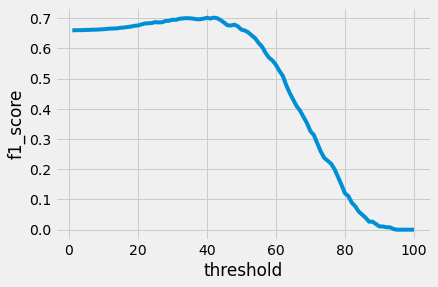

In [122]:
# graph
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

# Exercise 7.11

i) Estimate the probability of the weighted voting

In [51]:
y_pred.value_counts().to_frame('count').assign(percentage = lambda x: x/x.sum())

,count,percentage
0,,
1,770,0.513333
0,730,0.486667


ii) Modify the probability threshold and select the one that maximizes the F1-Score

In [131]:
f1_score.index(max(f1_score)),max(f1_score)

(41, 0.7021154945683248)

# Exercise 7.12

i) Estimate a logistic regression using as input the estimated classifiers

In [198]:
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))
X_train_3 = np.zeros((X_train.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    X_train_3[:, i] = clf.estimators_[i].predict(X_train)
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)

lr = LogisticRegressionCV(cv=5)
lr.fit(X_train_3, y_train)

y_pred = lr.predict(y_pred_all_)

#threshold = 0.1
#y_pred = (lr.predict(y_pred_all_) >= threshold).astype(np.int)
#y_pred = pd.DataFrame(y_pred)

In [257]:
y_pred = lr.fit(X_train_3, y_train).predict_proba(y_pred_all_)
y_pred = y_pred[:,1]

threshold = 0.5
y_pred = (y_pred >= threshold).astype(np.int)
y_pred = pd.DataFrame(y_pred)
y_pred.describe()

print("F1 score:",metrics.f1_score(y_test, y_pred))

F1 score: 0.666235446313066


In [141]:
# metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1 score:",metrics.f1_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.656
F1 score: 0.666235446313066
Precision: 0.6381660470879802
Recall: 0.6968876860622463


ii) Modify the probability threshold such that maximizes the F1-Score

In [252]:
threshold = 0
f1_score = []

for threshold in range(1,10,1):
    y_pred = (y_pred >= threshold/100).astype(np.int)
    #y_pred = pd.DataFrame(y_pred)
    f1_score.append(metrics.f1_score(y_test, y_pred))

In [253]:
y_pred.describe()


,0
count,1500.00000
mean,0.53800
std,0.49872
min,0.00000
25%,0.00000
50%,1.00000
75%,1.00000
max,1.00000


Text(0, 0.5, 'f1_score')

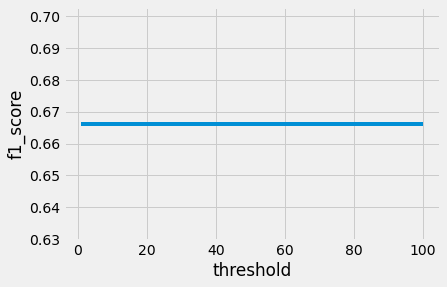

In [223]:
# graph
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(range(1,101), f1_score)
plt.xlabel('threshold')
plt.ylabel('f1_score')

In [202]:
f1_score.index(max(f1_score)),max(f1_score)

(0, 0.666235446313066)